### Partie 2 :

#### With a vector database

Now, we will work with the vector database stored in the file ./milvus_demo_image.db. To get this database, we vectorized the dataset https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals?resource=download which contain 5400 pictures of animals (see vectorize_dataset.ipynb).

We load the database (beware, it can return an error if the database is already loaded i.e if a file .milvius_demo_image.db.lock is created );

Warning : If you can't load the milvius database, try to use this command to see if the database is already used
```shell
ps aux | grep milvus
```

If it is the case, kill the processus, delete the .milivus_image_db.db.lock and reload the database


In [6]:
from pymilvus import MilvusClient
# We load the database

# Initialisation du client Milvus Lite
client = MilvusClient("milvus_image_db.db")


In [7]:
# Lister les collections disponibles
collections = client.list_collections()
print("Collections disponibles :", collections)

Collections disponibles : ['animals_vector_db']


We get the embedding model to vectorize the next images (a convolutional neural network here). Moreover, we also prepare the function preprocess which will normalized the image.

In [8]:
import torch
from torchvision import transforms

# Load the embedding model with the last layer removed
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.eval()

# Preprocessing for images
preprocess = transforms.Compose([
    transforms.Resize(256), # Change the size of the image (the longer side of the image will measure 256 pixels)
    transforms.CenterCrop(224), # Cut the image to have a 224*224 picture
    transforms.ToTensor(), # Change the image into a tensor
])

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /home/jovyan/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:24<00:00, 4.18MB/s]


We choose the image we will use as a query

In [13]:
path ='./img/img_test/Aigle.jpg'

In [10]:
from PIL import Image
device ="cpu"

# Function which get the image, which normalize it and convert it into a vector
def image_to_vector(path,preprocess):
    im = Image.open(path).convert('RGB') # Get the image
    preprocessed_img = preprocess(im)# We normalize it 
    preprocessed_img_3D = preprocessed_img.unsqueeze(0).to(device)  

    output = model(preprocessed_img_3D).squeeze() # Embed the image
    return output.tolist() # The vector database doesn't know what a tensor is

Finally, we seek the images the closest to the image you chose.

In [14]:
img_vector = image_to_vector(path,preprocess)

NB_IMAGES = 4 
res = client.search(
    collection_name="animals_vector_db",
    data=[img_vector],
    limit=NB_IMAGES, # We seek the 4 images the closest 
    output_fields=["path","animal"], # We seek the path of the images
)
res

data: ["[{'id': 171, 'distance': 0.8668934106826782, 'entity': {'animal': 'eagle', 'path': './animals_dataset/animals/animals/eagle/8d33099f2f.jpg'}}, {'id': 5172, 'distance': 0.8514520525932312, 'entity': {'animal': 'crow', 'path': './animals_dataset/animals/animals/crow/06a9c44c55.jpg'}}, {'id': 146, 'distance': 0.8397477865219116, 'entity': {'animal': 'eagle', 'path': './animals_dataset/animals/animals/eagle/3d9345d715.jpg'}}, {'id': 160, 'distance': 0.8350157737731934, 'entity': {'animal': 'eagle', 'path': './animals_dataset/animals/animals/eagle/76e6267bec.jpg'}}]"]

Let's see the images we got.

'query'

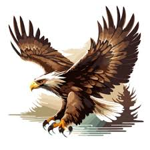

'results'

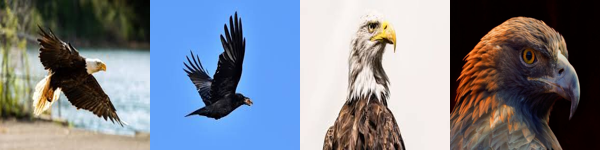

['eagle', 'crow', 'eagle', 'eagle']
[0.8668934106826782, 0.8514520525932312, 0.8397477865219116, 0.8350157737731934]


In [15]:
# We get the images close to the query
from IPython.display import display

images = []
distances = []
animals = []
for img_dict in res[0]:
    # We get the path of the image
    path_image = img_dict["entity"]["path"]
    distances.append(img_dict["distance"])
    animals.append(img_dict["entity"]["animal"])
    img = Image.open(path_image)
    img = img.resize((150, 150))
    images.append(img)

width = 150 * NB_IMAGES
height = 150 * 1
concatenated_image = Image.new("RGB", (width, height))

# Let's see what we got
for idx, img in enumerate(images):
    x = idx % 5
    y = idx // 5
    concatenated_image.paste(img, (x * 150, y * 150))
display("query")
display(Image.open(path).resize((150, 150)))
display("results")
display(concatenated_image)
print(animals)
print(distances)